<a href="https://colab.research.google.com/github/DAOTHITHUNGA/CS114.K21.KHTN/blob/master/ML_DOANCUOIKY_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###BÁO CÁO ĐỒ ÁN CUỐI KỲ MACHINE LEARNING 
####Đào Thị Thu Nga - 18521135 
###Đề tài : Nhận diện lá cây trong khuôn viên làng đại học
1. Mô tả bài toán 
2. Mô tả về bộ dữ liệu
3. Tiền xử lí dữ liệu 
4. Rút trích đặc trưng
5. Xây dựng mô hình 
6. So sánh và đánh giá kết quả 

###1. Mô tả bài toán
Đặt vấn đề: 


* Input: Ảnh chụp chính diện 1 lá cây

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Lisc_lipy.jpg/220px-Lisc_lipy.jpg)
* Output : Tên loại lá trong ảnh.

###2. Mô tả về bộ dữ liệu
- Tự xây dựng bộ dữ liệu bằng cách đi thu thập các loại lá cây phổ biến trong khuôn viên làng đại học.
- Lá cây được chụp bằng camera điện thoại có độ phân giải 3000*4000. Chụp chính diện dưới ánh sáng ban ngày,nền chụp trắng.
- Số lượng gồm 35 loại lá cây với mỗi lá là 20 mẫu lá (tổng cộng 700 lá).

<div><img src="https://scontent.fvca1-2.fna.fbcdn.net/v/t1.15752-9/116372726_604975703768888_4364683868426871152_n.png?_nc_cat=100&_nc_sid=b96e70&_nc_ohc=ArqiltL3UeoAX-IRAC1&_nc_ht=scontent.fvca1-2.fna&oh=0d20ed12089be8f66a710a2f84c726af&oe=5F48E2AE" width="400"/></div>

In [ ]:
#Truy cập vào ggdrive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#import thư viện cần thiết 
import os
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import glob
from tqdm import tqdm
import pickle 
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
%matplotlib inline

### 3. Tiền xử lý dữ liệu

  Em sử dụng 2 bộ dữ liệu : 
*  ORIGIN UIT LEAF DATASET: Bộ dữ liệu chụp chưa cắt background.
*  UIT LEAF DATASET(thử nghiệm): Bộ dữ liệu được tiền xử lý bằng cách cắt background ,xoá nhiễu bằng photoshop.
* Tất cả hình ảnh các loại lá đều được xoay theo cùng một hướng (đầu lá phải hướng lên trên).
* Trong quá trình chụp đặt tên label cho data. 

In [ ]:
#đường dẫn data
root = "/content/drive/My Drive/ORIGIN UIT LEAF DATASET"
#root = "/content/drive/My Drive/UIT LEAF DATASET"

Mỗi dataset em chia thủ công thành 2 tập train và test tương ứng với nhau:
- Tập train : Mỗi label chứa 15 lá (tỉ lệ 75%).
- Tập test  : Mỗi label chứa 5 lá (tỉ lệ 25%) ở tập test em chọn những lá nhiễu so với tập train.

In [ ]:
#Thử nghiệm lưu đọc ảnh bằng pickle
images_train = pickle.load(open('/content/drive/My Drive/b_data/cv_images_train','rb'))
images_test = pickle.load(open('/content/drive/My Drive/b_data/cv_images_test','rb'))

labels_train = pickle.load(open('/content/drive/My Drive/b_data/b_labels_train','rb'))
labels_test = pickle.load(open('/content/drive/My Drive/b_data/b_labels_test','rb'))

In [ ]:
#Read images
# TRAIN PART
images_train=[]
labels_train=[]
for dir_path in tqdm(glob.glob(root+"/train/*")):
    img_label = dir_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(dir_path, "*")):
        img = cv2.imread(img_path)
        if img is None:
          continue
        img = cv2.resize(img, (300,400))#scale ảnh về (300,400)
        images_train.append(img)
        labels_train.append(img_label)
print(len(images_train),len(labels_train))
# TEST PART
images_test=[]
labels_test=[]
for dir_path in tqdm(glob.glob(root+"/test/*")):
    img_label = dir_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(dir_path, "*")):
        img = cv2.imread(img_path)
        if img is None:
          continue
        img = cv2.resize(img, (300,400))
        images_test.append(img)
        labels_test.append(img_label)
print(len(images_test),len(labels_test))

  0%|          | 0/35 [00:00<?, ?it/s]

525 525


100%|██████████| 35/35 [01:52<00:00,  3.21s/it]

175 175


###4. Rút trích đặc trưng

Em thử nghiệm 2 loại rút feature là 
+ Hog(histogram of oriented gradients) : đạt kết quả cao 
+ sử dụng picxel của ảnh 

HOG: Mỗi ảnh chia thành các ô gọi là cell. Tiếp đến là Block, mỗi block sẽ gồm nhiều cell. Khi duyệt ảnh thì nó sẽ duyết tất các các block có kích thước do mình chọn. Chỗ này ý là nó sẽ duyệt các block có thể chồng lên nhau miễn là đủ số cell của block. Mỗi block thì nó sẽ vote hướng của mỗi cell trong đó. Số hướng thì được đó bởi biến orientations. 
nhân số block duyệt với số hướng orientations thì sẽ ra số features vector

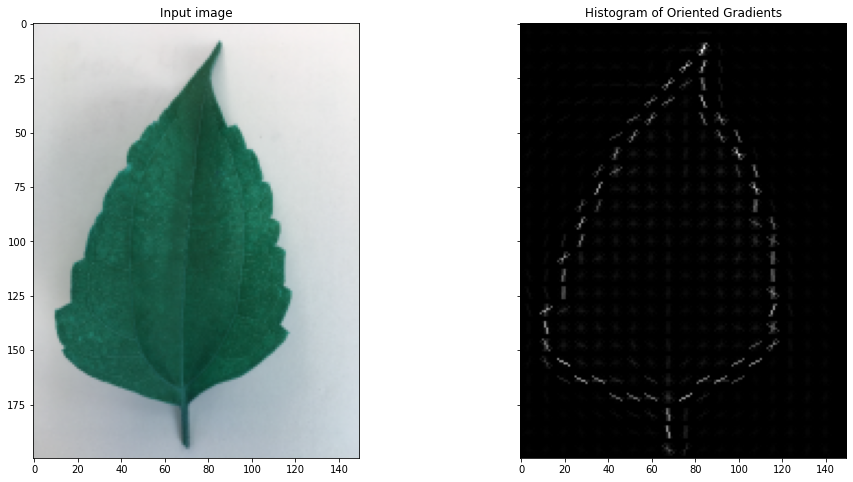

In [ ]:
#SHOW EXAMPLE OF HOG
test = resize(images_train[200],(200,150))
fd,img = hog(test, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 
ax1.imshow(test, cmap=plt.cm.gray) 
ax1.set_title('Input image') 
# Rescale histogram for better display 
ax2.imshow(img, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [ ]:
#FEATURE EXTRACTION
# TRAIN PATH
train_features=[]
for img in tqdm(images_train):
  test = resize(img,(200,150))
  fd,temp = hog(test, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
  train_features.append(np.reshape(fd,len(fd)))
# TEST PATH
test_features=[]
for img in tqdm(images_test):
  test = resize(img,(200,150))
  fd,temp = hog(test, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
  test_features.append(np.reshape(fd,len(fd)))

100%|██████████| 175/175 [00:25<00:00,  6.82it/s]


Tăng cường dữ liệu trên bộ train data.

In [ ]:
#DATA ARGUMENTATION
for img in tqdm(images_train):
  img=cv2.flip(img,1)#lật ảnh 
  test = resize(img,(200,150))
  fd,temp = hog(test, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
  train_features.append(np.reshape(fd,len(fd)))
#ADD LABELS
for i in range(len(labels_train)):
  labels_train.append(labels_train[i])

100%|██████████| 525/525 [01:19<00:00,  6.64it/s]


###5. Xây dựng mô hình

Sử dụng 4 mô hình


*   KNN
*   SVC
*   Logistic regression
*   Random Forest Classifier

Với độ đo 

*   F1

*   Độ đo accuracy



In [ ]:
#import thư viện cần thiết.
import pandas as pd, numpy as np, re, time
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

####a. KNN model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=1,p=2)
knn.fit(train_features,labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
#Calculate Result
#F1 score logistic regression
predict=knn.predict(test_features)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(labels_test,predict))

                   precision    recall  f1-score   support

          Ắc Ó       1.00      1.00      1.00         5
            Bàng       0.83      1.00      0.91         5
     Bằng Lăng       1.00      0.20      0.33         5
       Bông Gòn       1.00      0.60      0.75         5
      Bông Trang       1.00      0.80      0.89         5
              Bơ       0.00      0.00      0.00         5
             Chè       1.00      0.80      0.89         5
      Chôm Chôm       0.33      0.60      0.43         5
         Cỏ Lào       0.62      1.00      0.77         5
        Dark Star       1.00      0.20      0.33         5
   Giáng Hương       0.62      1.00      0.77         5
Hoa Chuông Vàng       1.00      1.00      1.00         5
    Hoa Dâm Bụt       1.00      0.20      0.33         5
       Hoa Giấy       1.00      0.80      0.89         5
         Hoa Lài       0.80      0.80      0.80         5
         Hoa Sứ       0.83      1.00      0.91       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




```
# Định dạng của đoạn này là mã
```

####b.Using linear support vector classifier

In [ ]:
print("Linear support vector")
lsvc = LinearSVC()
# training the model
lsvc.fit(train_features, labels_train)
print(lsvc.score(test_features, labels_test))

Linear support vector
0.8914285714285715


In [ ]:
#Calculate Result
#F1 score logistic regression
predict=lsvc.predict(test_features)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(labels_test,predict))

                   precision    recall  f1-score   support

          Ắc Ó       1.00      1.00      1.00         5
            Bàng       1.00      1.00      1.00         5
     Bằng Lăng       1.00      1.00      1.00         5
       Bông Gòn       1.00      0.80      0.89         5
      Bông Trang       1.00      1.00      1.00         5
              Bơ       1.00      1.00      1.00         5
             Chè       1.00      0.60      0.75         5
      Chôm Chôm       0.80      0.80      0.80         5
         Cỏ Lào       0.62      1.00      0.77         5
        Dark Star       1.00      0.80      0.89         5
   Giáng Hương       0.83      1.00      0.91         5
Hoa Chuông Vàng       1.00      1.00      1.00         5
    Hoa Dâm Bụt       1.00      0.60      0.75         5
       Hoa Giấy       1.00      0.80      0.89         5
         Hoa Lài       0.83      1.00      0.91         5
         Hoa Sứ       1.00      1.00      1.00       

####C. Logistic Regression

In [ ]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(train_features, labels_train)
print('Logistic Regression')
print(lr.score(test_features, labels_test))


Logistic Regression
0.8514285714285714


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
#Calculate Result
#F1 score logistic regression
predict=lr.predict(test_features)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(labels_test,predict))

                   precision    recall  f1-score   support

          Ắc Ó       1.00      1.00      1.00         5
            Bàng       1.00      1.00      1.00         5
     Bằng Lăng       0.80      0.80      0.80         5
       Bông Gòn       1.00      0.80      0.89         5
      Bông Trang       1.00      0.80      0.89         5
              Bơ       1.00      1.00      1.00         5
             Chè       1.00      0.20      0.33         5
      Chôm Chôm       0.80      0.80      0.80         5
         Cỏ Lào       0.62      1.00      0.77         5
        Dark Star       1.00      0.40      0.57         5
   Giáng Hương       0.83      1.00      0.91         5
Hoa Chuông Vàng       0.83      1.00      0.91         5
    Hoa Dâm Bụt       1.00      0.60      0.75         5
       Hoa Giấy       1.00      0.80      0.89         5
         Hoa Lài       0.56      1.00      0.71         5
         Hoa Sứ       1.00      1.00      1.00       

####d.Random Forest Classifier

In [ ]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
rfc.fit(train_features, labels_train)
print('Random Forest Classifier')
print(rfc.score(test_features, labels_test))    

Random Forest Classifier
0.48


In [ ]:
#Calculate Result
#F1 score logistic regression
predict=rfc.predict(test_features)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(labels_test,predict))

                   precision    recall  f1-score   support

          Ắc Ó       0.27      0.60      0.37         5
            Bàng       0.38      0.60      0.46         5
     Bằng Lăng       0.67      0.40      0.50         5
       Bông Gòn       0.50      0.60      0.55         5
      Bông Trang       0.40      0.40      0.40         5
              Bơ       0.33      0.60      0.43         5
             Chè       0.14      0.20      0.17         5
      Chôm Chôm       0.50      0.40      0.44         5
         Cỏ Lào       0.71      1.00      0.83         5
        Dark Star       0.00      0.00      0.00         5
   Giáng Hương       0.50      1.00      0.67         5
Hoa Chuông Vàng       0.43      0.60      0.50         5
    Hoa Dâm Bụt       0.00      0.00      0.00         5
       Hoa Giấy       0.50      0.60      0.55         5
         Hoa Lài       0.22      0.40      0.29         5
         Hoa Sứ       0.60      0.60      0.60       

Dự đoán 1 

###6.So sánh và đánh giá kết quả
- Histograms feature \\
KNN 67% \\
SVC 57.14% \\
Logistic Regression 61.17% \\
Random Forest Classifier 57.71% \\
- Raw feature và HOG 

![alt text](https://scontent.fdad1-1.fna.fbcdn.net/v/t1.15752-9/117594220_305249090753566_7826566815594679215_n.png?_nc_cat=105&_nc_sid=b96e70&_nc_ohc=FNc8EPRGVWEAX8AKUrM&_nc_ht=scontent.fdad1-1.fna&oh=febd0767d5fed33cbf7bcbdb95c70968&oe=5F5D457B)

# DEMO 1 ẢNH 

####DEMO ẢNH TRONG DATASET

In [ ]:
def PredictOneImage(path):
  query=cv2.imread(path)
  query = cv2.resize(query, (300,400))
  test = resize(query,(200,150))
  fd,temp = hog(test, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
  image_feature=np.reshape(fd,len(fd))
  print(lsvc.predict(np.array(image_feature).reshape(1,-1))[0])
  cv2_imshow(query)

Xà Cừ


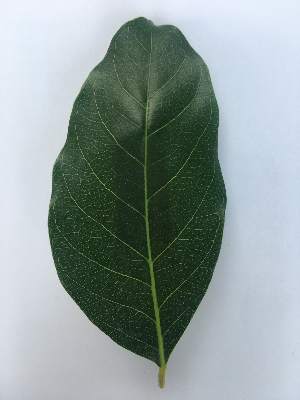

In [ ]:
test=root+"/test/Xà Cừ/Xà Cừ_ 3.JPG"
PredictOneImage(test)

####DEMO ẢNH ONLINE

Tràm


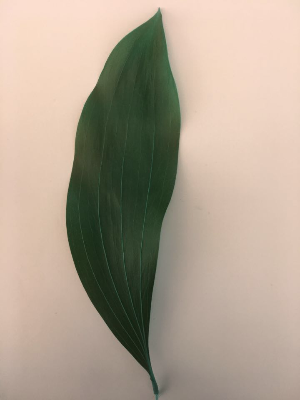

In [ ]:
#Using online Images
import PIL.Image as Image
import requests
from io import BytesIO
url="https://scontent.fdad2-1.fna.fbcdn.net/v/t1.15752-9/117606728_638596236759893_6334203704249755229_n.jpg?_nc_cat=111&_nc_sid=b96e70&_nc_ohc=tgC5-4-xr5YAX_ZC2y1&_nc_ht=scontent.fdad2-1.fna&oh=334f17be4ac03b6f42ae932a9973a1b8&oe=5F5CF1A2"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
cimg = np.array(img)
query = cv2.resize(cimg, (300,400))
test = resize(query,(200,150))
fd,temp = hog(test, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
image_feature=np.reshape(fd,len(fd))
print(lsvc.predict(np.array(image_feature).reshape(1,-1))[0])
cv2_imshow(query)


####DEMO ẢNH TỪ CAMERA

In [ ]:
def PredicCapture(path):
  query=cv2.imread(path)
  crop = query[:,320:]
  imgresize = cv2.resize(crop, (300,400))
  test = resize(imgresize,(200,150))
  fd,temp = hog(test, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
  image_feature=np.reshape(fd,len(fd))
  print(lsvc.predict(np.array(image_feature).reshape(1,-1))[0])
  cv2_imshow(imgresize)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='Captured_photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

/content/drive/My Drive/CAPTURE_PICTURE


<IPython.core.display.Javascript object>

Saved to Captured_photo.jpg
Hoa Dâm Bụt


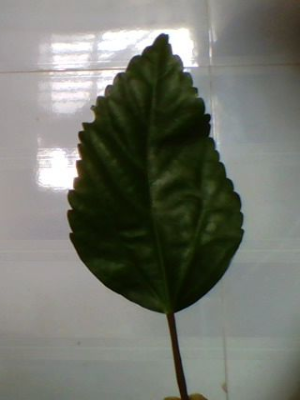

In [ ]:
%cd '/content/drive/My Drive/CAPTURE_PICTURE'
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  PredicCapture(filename)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))